<div  style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">

**Артем, привет!**

Меня зовут Василий Митров и я буду проверять твой проект. Предлагаю общаться на «ты». Если это неприемлемо, то дай мне знать и мы перейдем на «вы». 

Для удобства я оставлю комментарии в отдельных ячейках Markdown с заголовком «Комментарий ревьюера». Пожалуйста, не перемещай, не изменяй и не удаляй их - так наше общение будет более продуктивным. Я буду использовать цветовую разметку:

<div class="alert alert-danger" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера</b> 
    
✍ Так выделены самые важные замечания. Без их отработки проект не будет принят. При проверке я обращаю внимание не только на код, но и на интерпретацию и анализ результатов, а также соответствие данных техническому заданию.
</div>

<div class="alert alert-warning" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера</b> 
    
📝 Так выделены небольшие замечания или рекомендации. Постарайся, пожалуйста, учесть эти комментарии в этом проекте или в будущих проектах.
</div>

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера</b> 
    
👍 Так выделены все остальные комментарии, включая рекомендации, позитивные моменты или какие-то рассуждения и пояснения.
</div>

**Важные дополнения:**
    
* <u>Идеально, когда проект структурирован. Где названия разделов и подразделов будут записаны в ячейках [Markdown](https://paulradzkov.com/2014/markdown_cheatsheet/?).</u>
    

* <u>Проверь проект на работоспособность перед отправкой на проверку. Сделать это можно так: `Kernel -> Restart And Run All -> Restart And Run All Cells` предварительно сохранив проект нажав на дискету в левом верхнем углу. Это важный навык, который тебе пригодится как на собеседовании, при выполнении тестового задания, так и перед совещанием у руководства компании. Помни, ревьюеры не вносят изменения в код, даже если это путь к датасету или ячейка в неверном формате (code/mardown).</u>
    
Давай работать над проектом в диалоге: если ты что-то меняешь в проекте или отвечаешь на мои комментарии — пиши об этом. Мне будет легче отследить изменения, если ты выделишь свои комментарии:

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<b>Комментарий студента</b> 
    
Например, вот так. Также, если есть какие-то вопросы, или что-то осталось непонятным по ревью - спрашивай в таких блоках и я постараюсь дать ответ.
</div>

---

# Введение

## Цель работы

Проанализировать данные о продаже компьютерных игр и выявить факторы, влияющие на успешность игры.


## План работы
1. Подготовка данных:
  - Замена названия столбцов.
  - Исправление ошибок в данных (пропуски, аномалии, дубликаты).
  - Приведение данных к нужным типам.
  - Добавление новых признаков (например, суммарные продажи).
2. Исследовательский анализ данных:
  - Анализ продаж игр по платформам, жанрам, годам.
  - Определение зависимости продаж от оценок критиков и пользователей.
  - Выявление самых популярных и прибыльных игр.
  - Исследование жизненного цикла игровых платформ.
3. Формулирование выводов и рекомендаций:
  - Описание потенциально популярного продукта.
  - Определение ключевых факторов, влияющих на продажи игр.
  - Рекомендации по планированию рекламных кампаний на 2017 год.

## Описание данных:
Набор данных содержит информацию о продажах компьютерных игр по всему миру до 2016 года. В нем представлены следующие характеристики:

- Название игры
- Платформа (например, PC, PS4, Xbox)
- Год выпуска
- Жанр
- Продажи в разных регионах (Северная Америка, Европа, Япония и другие)
- Оценки критиков и пользователей

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Вступление в работу очень важно. Так ты поясняешь то, чему она посвящена. Еще лучше будет, если ты сделаешь план работы с гиперссылками. Да, есть плагин ToC. Но хорошо бы уметь реализовывать интерактивный план проекта вручную. Как это реализовать - смотри по [ссылке](https://stackoverflow.com/questions/49535664/how-to-hyperlink-in-a-jupyter-notebook/49717704)
</div>

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<b>Комментарий студента v.1</b>
Я делаю работу в Google Colab. Там ToC отображается автоматом. В Kaggle тоже такое есть.
При этом в автоматическом ToC хорошо видно заголовки разных уровней, я сам постоянно им пользуюсь для перехода по разделам.

С другой стороны с ToC, сделанным вручную могут быть сложности. У зрителя может не оказаться нужного плагина, код пухнет...

Можно использовать ссылки внутри текста, но в этой работе пока не было такой необходимости.
</div>

# Предобработка данных

## Чтение данных

In [1]:
%%capture
!pip install fuzzywuzzy
!pip install python-Levenshtein

In [2]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Правильно, что весь импорт ты проводишь в первой ячейке работы. Так твой коллега, запускающий работу, будет в курсе используемых в ней библиотек и сможет при необходимости быстро настроить окружение.
</div>

In [3]:
try:
    df = pd.read_csv('games.csv', sep=',')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv', sep=',')

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 Здорово, что следишь за универсальностью загрузки данных и используешь `try-except` блок.
</div>

In [4]:
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format

## Пример данных

In [5]:
df.sample(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
1861,Omerta: City of Gangsters,PS3,2011.00,Simulation,0.52,0.42,0.00,0.15,NaN,NaN,NaN
816,UFC 2009 Undisputed,X360,2009.00,Fighting,1.48,0.39,0.00,0.19,83.00,7.9,T
6422,Fish Tycoon,DS,2007.00,Simulation,0.24,0.00,0.00,0.02,46.00,7,E
5017,Mercenaries 2: World in Flames,PS2,2008.00,Shooter,0.21,0.00,0.00,0.17,49.00,7.4,T
6485,Major League Baseball 2K9,Wii,2009.00,Sports,0.24,0.00,0.00,0.02,61.00,4.5,E
10646,Tom Clancy's Ghost Recon: Predator,PSP,2010.00,Shooter,0.07,0.02,0.00,0.02,54.00,tbd,T
9554,Backyard Baseball,GC,2003.00,Sports,0.10,0.03,0.00,0.00,70.00,9.4,E
9658,LEGO Marvel's Avengers,PSV,2016.00,Action,0.02,0.07,0.00,0.03,NaN,6.6,E10+
267,Batman: Arkham Asylum,PS3,2009.00,Action,2.24,1.31,0.07,0.61,91.00,8.9,T
4887,Dark Souls III,XOne,2016.00,Role-Playing,0.26,0.09,0.00,0.04,87.00,8.6,NaN


## Описание колонок

| Колонка | Старое название | Описание |
|---|---|---|
| `name` | `Name` | Название игры |
| `platform` | `Platform` | Платформа |
| `year_of_release` | `Year_of_Release` | Год выпуска |
| `genre` | `Genre` | Жанр игры |
| `na_sales` | `NA_sales` | продажи в Северной Америке (миллионы проданных копий) |
| `eu_sales` | `EU_sales` | продажи в Европе (миллионы проданных копий) |
| `jp_sales` | `JP_sales` | продажи в Японии (миллионы проданных копий) |
| `other_sales` | `Other_sales` | продажи в других странах (миллионы проданных копий) |
| `critic_score` | `Critic_Score` | оценка критиков (максимум 100) |
| `user_score` | `User_Score` | оценка пользователей (максимум 10) |
| `rating` | `Rating` | рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию. |
| `total_sales` |  | суммарные продажи во всех регионах (миллионы проданных копий); `= na_sales + eu_sales + jp_sales + other_sales` |

Описание значений поля `rating`

| Рейтинг | Возраст | Комментарий |
|---|---|---|
| `EC` | 3 | Early childhood |
| `E` | 6 | Everyone |
| `E10+` | 10 | Everyone 10 and older |
| `T` | 13 | Teen |
| `M` | 17 | Mature |
| `AO` | 18 | Adults Only 18+ |

## Обзор данных

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Набор содержит 16715 записей.

Наименование полей следует скорректировать.

В некоторых полях есть значительные пропуски.

Изменить тип некоторых полей.

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Хорошая вводная часть.

Рекомендую создать универсальную функцию, которая будет принимать на вход датафрейм, а на выходе она будет выводить всего нужные характеристики, например, head, describe, info, дубликаты и т.п.
</div>

## Переименование колонок

Названия колонок перевести в нижний регистр.

In [7]:
df.columns = map(str.lower, df.columns)
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

## Удаление пропусков

Записи с пропусками в полях `Name`, `Year_of_Release` и `Genre` не содержат полезной информации для исследования. Их можно удалить, они составляют меньше 2% набора данных. Скорее всего, эти пропуски полностью случайны, возникли при вводе данных.

In [8]:
(pd.DataFrame(round(df.isna().mean()*100, 2), columns=['percent'])
 .assign(count=df.isna().sum())
 .style.background_gradient('coolwarm'))

,percent,count
name,0.01,2
platform,0.00,0
year_of_release,1.61,269
genre,0.01,2
na_sales,0.00,0
eu_sales,0.00,0
jp_sales,0.00,0
other_sales,0.00,0
critic_score,51.32,8578
user_score,40.09,6701


<div class="alert alert-warning" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
📝 
Также, помимо абсолютных значений мы можем посмотреть долю пропусков, и на основании этого принять решение о удалении, замене либо игнорировании пропусков, например: `pd.DataFrame(round(df.isna().mean()*100,1)).style.background_gradient('coolwarm')`
    
    
</div>

In [9]:
df = df.dropna(subset = ['name', 'year_of_release', 'genre'])

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Верно, доля пропусков здесь менее 5% и для экономии времени их можно удалить.
</div>

Поле `rating` категориальное, поэтому, для неизвестных значений можно установить общее значение `Unknown`, это не вызовет искажений в числовых расчетах.

In [10]:
df['rating'] = df['rating'].fillna('Unknown')
df['rating'].unique()

array(['E', 'Unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Молодец! Верное решение. Что касается рейтинга ESRB, пропуски в этой колонке не являются просто ошибкой заполнения данных, а несут определенную информацию. Что бы проанализировать ее, на пропуски следует поставить заглушку.
</div>

[Описание системы рейтингов](https://en.wikipedia.org/wiki/Entertainment_Software_Rating_Board)

Рейтинг `K-A` был переименован в `E`. Сделаем также.

`RP` означает `Rating Pending` или `Рейтинг ожидается`. Есть только одна такая запись. Для наших целей удобнее включить ее в рейтинг `Unknown`.

In [11]:
df['rating'] = df['rating'].replace('K-A', 'E')
df['rating'] = df['rating'].replace('RP', 'Unknown')

df['rating'].value_counts()


Unknown    6677
E          3924
T          2905
M          1536
E10+       1393
EC            8
AO            1
Name: rating, dtype: int64

## Дубликаты

In [12]:
df.duplicated().sum()

0

Явных дубликатов нет.

In [13]:
duplicates = df[df.duplicated(subset=['name', 'platform'], keep=False)]
duplicates

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.00,Sports,2.11,0.22,0.00,0.23,83.00,5.5,E
1190,Need for Speed: Most Wanted,X360,2012.00,Racing,0.62,0.78,0.01,0.15,83.00,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.00,Racing,1.00,0.13,0.02,0.10,83.00,8.5,T
5972,Need for Speed: Most Wanted,PC,2005.00,Racing,0.02,0.23,0.00,0.04,82.00,8.5,T
11715,Need for Speed: Most Wanted,PC,2012.00,Racing,0.00,0.06,0.00,0.02,82.00,8.5,T
16230,Madden NFL 13,PS3,2012.00,Sports,0.00,0.01,0.00,0.00,83.00,5.5,E


Считаем, что перезапуски игр - это отдельные игры.
https://ru.wikipedia.org/wiki/Need_for_Speed:_Most_Wanted_(2012)

Поэтому, при поиске дубликатов учитываем год выпуска.


In [14]:
duplicates = df[df.duplicated(subset=['name', 'platform', 'year_of_release'], keep=False)]
duplicates

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.00,Sports,2.11,0.22,0.00,0.23,83.00,5.5,E
16230,Madden NFL 13,PS3,2012.00,Sports,0.00,0.01,0.00,0.00,83.00,5.5,E


Есть две записи об одной игре. Складываем суммы продаж.

In [15]:
# Группировать и суммировать значения sales
agg_functions = {
    'na_sales': 'sum',
    'eu_sales': 'sum',
    'jp_sales': 'sum',
    'other_sales': 'sum',
    'critic_score': 'max',
    'user_score': 'max',
    'rating': 'first',
}

df = df.groupby(['name', 'platform', 'year_of_release', 'genre']).agg(agg_functions).reset_index()

duplicates = df[df.duplicated(subset=['name', 'platform', 'year_of_release'], keep=False)]
duplicates

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Молодец, что не забываешь про  дубликаты.
</div>

## Добавление вычисляемых полей

Поле `total_sales` описано выше.

In [16]:
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis = 1)

# Для проверки корреляций пригодиться допустимый возраст в числовом виде 
def get_rating_age(rating):
    if rating == 'EC':
        return 3
    elif rating == 'E':
        return 6
    elif rating == 'E10+':
        return 10
    elif rating == 'T':
        return 13
    elif rating == 'M':
        return 17
    elif rating == 'AO':
        return 18
    else:
        return None
df['rating_age'] = df['rating'].apply(get_rating_age)


# Создаем словарь для соответствия жанров и чисел
# Добавляем новую колонку с цифровыми значениями жанров
genre_mapping = {genre: i for i, genre in enumerate(df['genre'].unique())}
df['genre_code'] = df['genre'].map(genre_mapping)

df.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,rating_age,genre_code
3988,Escape from Bug Island,Wii,2006.00,Action,0.04,0.01,0.01,0.00,37.00,5,M,0.06,17.00,4
11637,SOCOM: U.S. Navy SEALs Fireteam Bravo,PSP,2005.00,Shooter,1.03,0.00,0.01,0.08,82.00,8.6,M,1.12,17.00,6
8840,Myself; Yourself,PS2,2007.00,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,Unknown,0.01,NaN,2
15756,Where's Waldo? The Fantastic Journey,Wii,2009.00,Adventure,0.17,0.00,0.00,0.01,NaN,tbd,E,0.18,6.00,2
605,Army Men 3D,PS,1999.00,Action,1.10,0.14,0.00,0.04,NaN,NaN,Unknown,1.28,NaN,4


## Изменение типов данных

Привести поле `year_of_release` к типу данных `int`.

Привести поле `critic_score` к типу данных `float`. Пропущенные значения остаются NaN.

Привести поле `user_score` к типу данных `float`. Пропущенные значения остаются NaN. Не удалось найти корреляцию значения `tbd` (to be determined) с другими колонками. Скорее всего, это случайный пропуск. Так как восстановить данные мы не можем, конвертируем в `NaN`.

<div class="alert alert-danger" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
✍ 
А что у нас по значению tbd, которое в ТЗ нас просят рассмотреть и объяснить, как его обработать?
</div>

In [17]:
df['user_score_is_tbd'] = df['user_score'] == 'tbd'
df.corr()['user_score_is_tbd']

year_of_release      0.07
na_sales            -0.07
eu_sales            -0.08
jp_sales            -0.10
other_sales         -0.07
critic_score        -0.23
total_sales         -0.09
rating_age          -0.34
genre_code           0.07
user_score_is_tbd    1.00
Name: user_score_is_tbd, dtype: float64

In [18]:
df['year_of_release'] = df['year_of_release'].astype('int')
df['critic_score'] = df['critic_score'].astype('float')
df['user_score'] = df['user_score'].replace('tbd', np.nan)
df['user_score'] = df['user_score'].astype('float')
df['user_score'] = df['user_score'].replace(0.0, np.nan)
df.dtypes

name                  object
platform              object
year_of_release        int64
genre                 object
na_sales             float64
eu_sales             float64
jp_sales             float64
other_sales          float64
critic_score         float64
user_score           float64
rating                object
total_sales          float64
rating_age           float64
genre_code             int64
user_score_is_tbd       bool
dtype: object

## Описание данных

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               16443 non-null  object 
 1   platform           16443 non-null  object 
 2   year_of_release    16443 non-null  int64  
 3   genre              16443 non-null  object 
 4   na_sales           16443 non-null  float64
 5   eu_sales           16443 non-null  float64
 6   jp_sales           16443 non-null  float64
 7   other_sales        16443 non-null  float64
 8   critic_score       7982 non-null   float64
 9   user_score         7461 non-null   float64
 10  rating             16443 non-null  object 
 11  total_sales        16443 non-null  float64
 12  rating_age         9766 non-null   float64
 13  genre_code         16443 non-null  int64  
 14  user_score_is_tbd  16443 non-null  bool   
dtypes: bool(1), float64(8), int64(2), object(4)
memory usage: 1.8+ MB


In [20]:
df.sample(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,rating_age,genre_code,user_score_is_tbd
9987,PES 2009: Pro Evolution Soccer,PS3,2008,Sports,0.11,1.33,0.40,0.26,NaN,NaN,Unknown,2.10,NaN,3,False
508,Ape Escape 2,PS2,2002,Platform,0.12,0.09,0.38,0.03,82.00,8.40,E,0.62,6.00,1,False
334,Alien Hominid,GC,2004,Shooter,0.07,0.02,0.00,0.00,78.00,8.50,T,0.09,13.00,6,False
5557,Harry Potter and the Deathly Hallows - Part 2,PC,2011,Action,0.05,0.04,0.00,0.01,43.00,5.00,Unknown,0.10,NaN,4,False
3880,Eat Lead: The Return of Matt Hazard,PS3,2009,Shooter,0.09,0.02,0.00,0.01,51.00,6.50,T,0.12,13.00,6,False
1564,Brunswick Circuit Pro Bowling,N64,1999,Sports,0.05,0.01,0.00,0.00,NaN,NaN,Unknown,0.06,NaN,3,False
5416,Gundam Breaker,PS3,2013,Action,0.00,0.00,0.26,0.00,NaN,NaN,Unknown,0.26,NaN,4,False
12406,Sky Dancers,GBA,2005,Action,0.02,0.01,0.00,0.00,NaN,NaN,Unknown,0.03,NaN,4,False
5432,Gunslingers,Wii,2010,Shooter,0.07,0.06,0.00,0.02,NaN,NaN,T,0.15,13.00,6,True
1898,Carmageddon: Max Damage,PS4,2016,Action,0.01,0.00,0.00,0.00,51.00,5.50,M,0.01,17.00,4,False


In [21]:
df.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales,rating_age,genre_code
count,16443.00,16443.00,16443.00,16443.00,16443.00,7982.00,7461.00,16443.00,9766.00,16443.00
mean,2006.49,0.26,0.15,0.08,0.05,68.99,7.13,0.54,10.38,4.73
std,5.88,0.82,0.51,0.31,0.19,13.92,1.50,1.56,4.09,3.00
min,1980.00,0.00,0.00,0.00,0.00,13.00,0.20,0.00,3.00,0.00
25%,2003.00,0.00,0.00,0.00,0.00,60.00,6.40,0.06,6.00,3.00
50%,2007.00,0.08,0.02,0.00,0.01,71.00,7.50,0.17,10.00,4.00
75%,2010.00,0.24,0.11,0.04,0.03,79.00,8.20,0.47,13.00,7.00
max,2016.00,41.36,28.96,10.22,10.57,98.00,9.70,82.54,18.00,11.00


Есть существенные пропуски данных в полях `critic_score`, `user_score` и `rating`. Удалить столько записей нельзя, это слишком большой объем данных.

## Гистограммы числовых столбцов таблицы

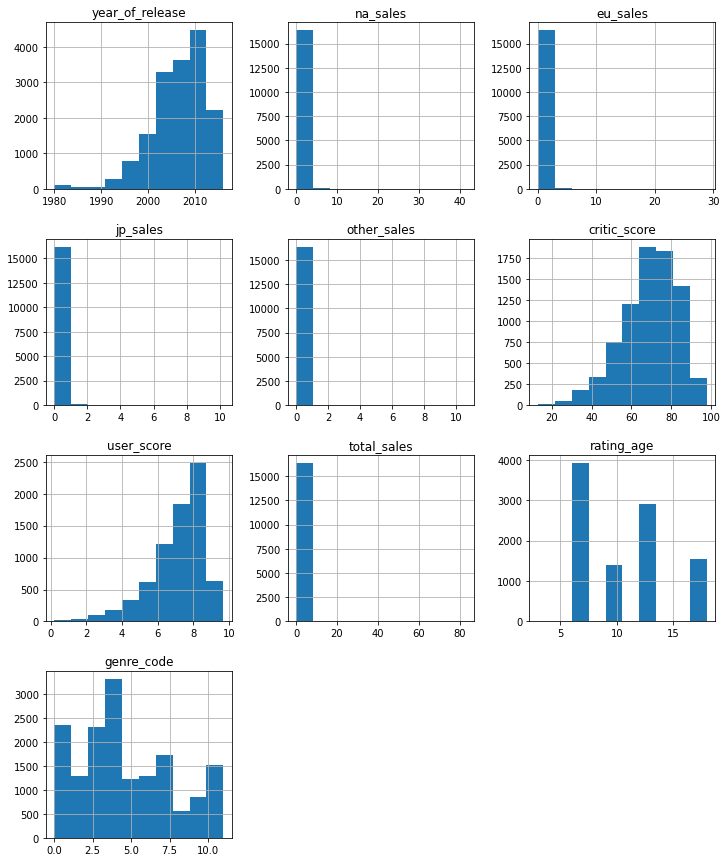

In [22]:
df.hist(figsize=(12, 15));

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Предупреждения перед графиками можно убрать одним из способов:
    
1. В конец кода добавить `plt.show()`, но для этого нужно вызвать библиотеку matplotlib.pyplot as plt
2. В конец кода добавить `;`
</div>

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<b>Комментарий студента v.1</b>
Интересно! А что делает ; в конце? Почему это работает?
</div>

## Выводы

В рамках предобработки были:
- скорректированы названия и типы колонок, добавлены вычисляемые колонки для удобства дельнейшего анализа;
- удалены записи с явными пропусками, которые могли бы помешать анализу данных. Остались пропуски в колонках, которые мы не можем корректно заполнить. Необходимость заполнять поля искуственными данными в данный момент не видим, поэтому оставляем пропуски. Возможный алгоритм заполнения пропусков зависит от целей исследования.

В итоге из начальных 16715 записей осталось 16443. Предварительная обработка повлияла на объем данных в пределах 2%.

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Отлично, мы превели первичный анализ и познакомились с данными. Приступим к исследовательскому анализу.
</div>

# Анализ данных

- Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Шаг 4. Составьте портрет пользователя каждого региона
Определите для пользователя каждого региона (NA, EU, JP):

- Самые популярные платформы (топ-5). Опишите различия в долях продаж.
- Самые популярные жанры (топ-5). Поясните разницу.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Шаг 5. Напишите общий вывод

## Количество игр в разные годы

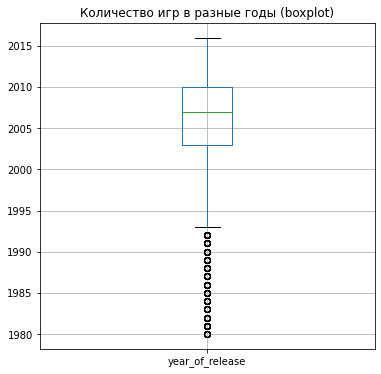

Нижний ус: 1992.5


In [23]:
df.boxplot('year_of_release',figsize=(6, 6))
plt.title('Количество игр в разные годы (boxplot)')
plt.show()

quartiles = df['year_of_release'].describe()
iqr = quartiles['75%'] - quartiles['25%']
print(f"Нижний ус:", quartiles['25%'] - 1.5 * iqr)

Значения раньше 1993 года считаем выбросами, эти данные не представляют интереса, можно удалить.

In [24]:
df = df[df['year_of_release'] >= 1993]

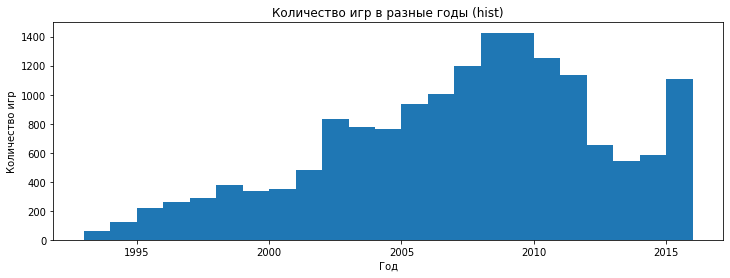

In [25]:
df['year_of_release'].plot(
    kind='hist',
    title='Количество игр в разные годы (hist)',
    xlabel='Год',
    ylabel='Количество игр',
    bins=len(df['year_of_release'].unique()) - 1,
    figsize=(12, 4),
)
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.show()

<div class="alert alert-warning" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
📝 
При работе с временными данными, особенно когда речь идет о визуализации, важно выбирать правильные методы представления информации.

* Линейные графики и столбчатые диаграммы - лучший выбор для временных рядов. Они показывают динамику изменений во времени и позволяют легко уловить тренды и аномалии.

* Гистограммы - полезны для демонстрации распределения данных. Однако нужно быть осторожным при использовании гистограмм для временных данных. Неправильный выбор интервалов может исказить восприятие данных. Если использовать гистограмму, то необходимо тщательно выберать интервалы.



Ключ к успешной визуализации - в понимании датасета и выборе правильных инструментов для демонстрации ключевой информации.
</div>

<div class="alert alert-danger" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
✍ 
Обрати, пожалуйста, внимание на оформление графиков в проекте. Важно, чтобы у каждого графика было название, а оси были четко подписаны. Пожалуйста, пройдись по всем графикам и убедись в их корректном оформлении.
    
Помни, график — это инструмент общения с заказчиком. Он должен быть ясным, лаконичным и информативным.
</div>

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<b>Комментарий студента v.1</b> 
В Google Colab подписи работают при вызове вида    
<pre>
df['year_of_release'].plot(
    kind='hist',
    title='Количество игр в разные годы (hist)',
    xlabel='Год',
    ylabel='Количество игр',
    bins=len(df['year_of_release'].unique()) - 1,
    figsize=(12, 4),
)
</pre>

Похоже, что в Jupyter надо вызывать отдельные методы
<pre>
plt.xlabel('Год')
plt.ylabel('Количество игр')
</pre>

Я планировал показывать заказчику в Google.
    
</div>


Наибольшее количество игр выпускалось в 2008 и 2009 годах.

<div class="alert alert-danger" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
✍ 
А с какого периода начался рост и какой период не значим для анализа?
</div>

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<b>Комментарий студента v.1</b> 
Я не совсем понял вопрос. Рост чего?

Про количество игр я указал, что данные до 1993 года точно не нужны. Необходимость других данных зависит от задачи. Для оценки срока жизни платформ нужны данные за срок, превышающий срок жизни платформ. Для анализа текущей ситуации и прогноза на следующий год достаточно 2-3 года.
</div>

## Игровые платформы

In [26]:
print('Общее количество платформ:', len(df['platform'].unique()))

Общее количество платформ: 29


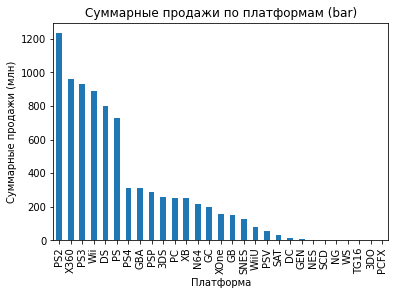

In [27]:
platforms = df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platforms.plot(
    kind='bar',
    title='Суммарные продажи по платформам (bar)',
)
plt.xlabel('Платформа')
plt.ylabel('Суммарные продажи (млн)')
plt.show()

In [28]:
platforms = df.groupby('platform').agg(
    total_sales=('total_sales', 'sum'),
    year_min=('year_of_release', 'min'),
    year_max=('year_of_release', 'max')
).reset_index().sort_values(by='total_sales', ascending=False)
platforms

,platform,total_sales,year_min,year_max
14,PS2,1233.56,2000,2011
26,X360,961.24,2005,2016
15,PS3,931.34,2006,2016
24,Wii,891.18,2006,2016
3,DS,802.76,2004,2013
13,PS,727.58,1994,2003
16,PS4,314.14,2013,2016
5,GBA,312.88,2000,2007
17,PSP,289.53,2004,2015
1,3DS,257.81,2011,2016


In [29]:
top_platforms = df.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5).index
print('Наиболее популярные платформы за все время:')
print(*top_platforms, sep=', ')

Наиболее популярные платформы за все время:
PS2, X360, PS3, Wii, DS


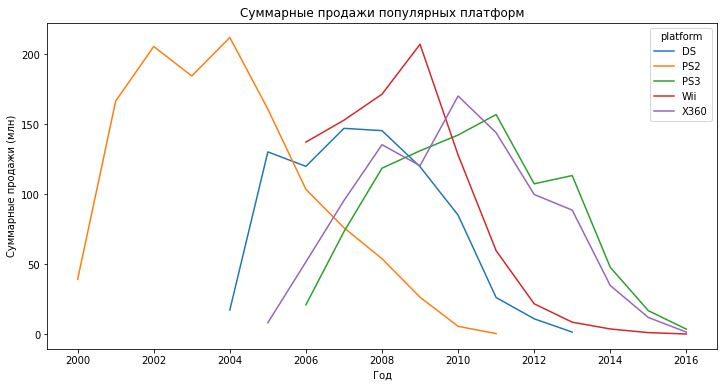

In [30]:
df_top = df[df['platform'].isin(top_platforms)]
# create a pivot table with platforms as columns and years as rows
platform_sales = df_top.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
# plot the sales for each platform
platform_sales.plot(kind='line', figsize=(12, 6))
plt.title('Суммарные продажи популярных платформ')
plt.xlabel('Год')
plt.ylabel('Суммарные продажи (млн)')
plt.show()

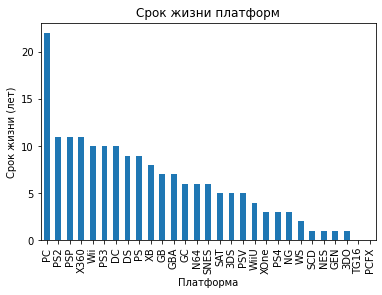

In [31]:
lifespan_all = df.groupby('platform')['year_of_release'].agg(['min', 'max'])
lifespan_all['lifespan'] = lifespan_all['max'] - lifespan_all['min']
lifespan_all = lifespan_all.sort_values(by='lifespan', ascending=False)

lifespan_all['lifespan'].plot(
    kind='bar',
    title='Срок жизни платформ',
    xlabel='Платформа',
    ylabel='Срок жизни (лет)',
);

In [32]:
lifespan_all['lifespan'].describe()

count   29.00
mean     6.10
std      4.72
min      0.00
25%      3.00
50%      6.00
75%      9.00
max     22.00
Name: lifespan, dtype: float64

In [33]:
lifespan_top = df[df['platform'].isin(top_platforms)].groupby('platform')['year_of_release'].agg(['min', 'max'])
lifespan_top['lifespan'] = lifespan_top['max'] - lifespan_top['min']

lifespan_top['lifespan'].describe()

count    5.00
mean    10.20
std      0.84
min      9.00
25%     10.00
50%     10.00
75%     11.00
max     11.00
Name: lifespan, dtype: float64

Средний и медианный срок жизни платформы 6 лет.

Средний и медианный срок жизни популярных платформ 10 лет.


<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Жизненный цикл определен верно.
</div>

## Актуальный период

Будем рассматривать данные за 2014-2016 годы.

Представляется разумным выбрать актуальный период 2-3 года.

Данные за 1 год не позволят выявить тенденции.

Срок жизни платформы около 10 лет — это слишком большой период для анализа, так как за это время рынок игр может сильно измениться, появляются новые жанры, технологии и тренды.

Использование данных за 2-3 года позволит:
- Учесть актуальные тенденции: В игровой индустрии тренды меняются очень быстро. Данные за 2-3 года отражают текущую ситуацию на рынке.
- Сосредоточиться на жизненном цикле популярных платформ: Большинство платформ не существуют 10 лет. Анализ данных за 2-3 года позволит оценить продажи на пике популярности платформ и сделать более точный прогноз.
- Исключить влияние устаревших данных: Игры, выпущенные 5-10 лет назад, не релевантны для прогнозирования продаж в 2017 году.

Таким образом, анализ данных за 2-3 года позволит построить более точный прогноз на 2017 год, учитывая динамику рынка и жизненный цикл игровых платформ.

Данные за актуальный период храним в переменной `df3`.

In [34]:
df3 = df[df['year_of_release'] >= 2014].sort_values(by='total_sales', ascending=False)
df3['total_sales'] = df3[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis = 1)
df3.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,rating_age,genre_code,user_score_is_tbd
10598,Prison Architect,XOne,2016,Action,0.01,0.00,0.00,0.00,74.00,6.70,Unknown,0.01,NaN,4,False
7888,Mario Party: Star Rush,3DS,2016,Misc,0.08,0.13,0.08,0.02,68.00,6.80,E,0.31,6.00,7,False
490,Anno 2205,PC,2015,Strategy,0.02,0.22,0.00,0.02,72.00,5.90,E10+,0.26,10.00,10,False
10152,Persona 5,PS3,2016,Role-Playing,0.00,0.00,0.11,0.00,NaN,NaN,Unknown,0.11,NaN,0,False
10217,Phantasy Star Online 2: Episode 3 Deluxe Package,PSV,2015,Action,0.00,0.00,0.03,0.00,NaN,NaN,Unknown,0.03,NaN,4,False


<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Верно. Для целей прогнозирования продаж на следующий год даже в традиционных бизнесах редко берут данные более чем за 2-3 года. А в такой динамично меняющейся индустрии, как компьютерные игры и вовсе не стоит брать слишком большой временной интервал - иначе обязательно захватим уже отжившие тренды. Но и очень короткий период не подходит для прогнозирования, так что надо выбирать золотую середину (но не менее 2-х полных лет и не более 5 лет).
</div>

## Продажи платформ

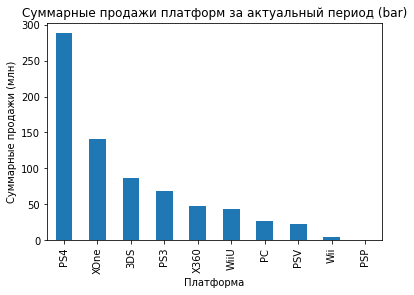

In [35]:
platforms3 = df3.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platforms3.plot(
    kind='bar',
    title='Суммарные продажи платформ за актуальный период (bar)',
    xlabel='Платформа',
    ylabel='Суммарные продажи (млн)',
)
plt.show()

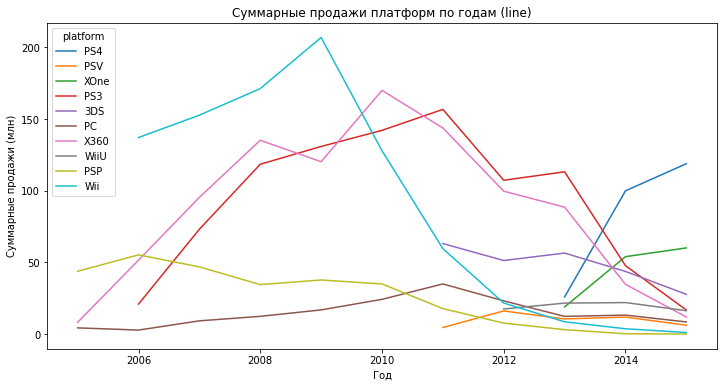

In [36]:
platform_sales = df.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
# Отображаем только актуальные платформы
platform_sales = platform_sales[df3['platform'].value_counts().index]
platform_sales = platform_sales[platform_sales.index >= 2005]
platform_sales = platform_sales[platform_sales.index <= 2015]
platform_sales.plot(kind='line', figsize=(12, 6))
plt.title('Суммарные продажи платформ по годам (line)')
plt.xlabel('Год')
plt.ylabel('Суммарные продажи (млн)')
plt.show()

Данные за 2016 год неполные, поэтому не рассматриваем их для оценки динамики. Видно, что растут только PS4 и XOne. Они же лидеры по продажам.

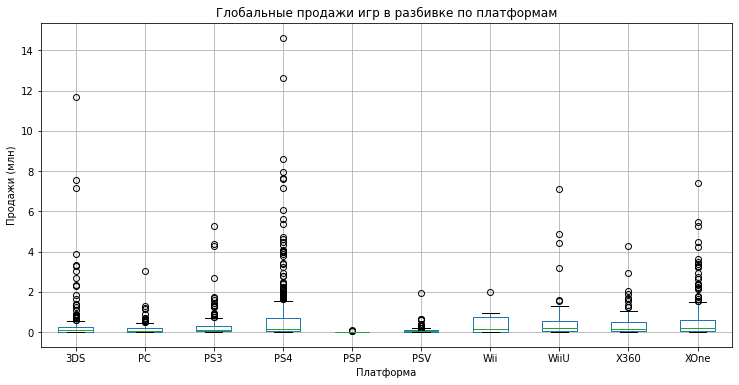

In [37]:
df3.boxplot('total_sales', by='platform', figsize=(12, 6))
plt.title('Глобальные продажи игр в разбивке по платформам')
plt.suptitle('')
plt.xlabel('Платформа')
plt.ylabel('Продажи (млн)')
plt.show()

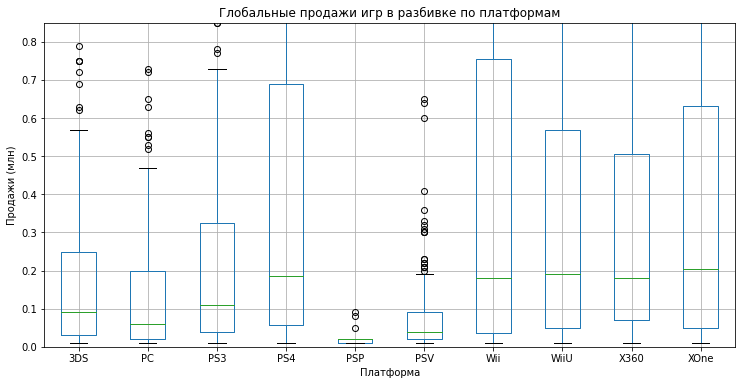

In [38]:
df3.boxplot('total_sales', by='platform', figsize=(12, 6))
plt.title('Глобальные продажи игр в разбивке по платформам')
plt.suptitle('')
plt.xlabel('Платформа')
plt.ylabel('Продажи (млн)')
plt.ylim(0, 0.85)
plt.show()

In [39]:
df3.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,212.00,0.41,1.19,0.01,0.03,0.09,0.25,11.68
PC,151.00,0.18,0.33,0.01,0.02,0.06,0.20,3.05
PS3,219.00,0.31,0.63,0.01,0.04,0.11,0.33,5.27
PS4,376.00,0.77,1.61,0.01,0.06,0.18,0.69,14.63
PSP,13.00,0.03,0.03,0.01,0.01,0.02,0.02,0.09
PSV,295.00,0.08,0.14,0.01,0.02,0.04,0.09,1.96
Wii,11.00,0.46,0.63,0.01,0.04,0.18,0.76,2.01
WiiU,73.00,0.59,1.16,0.01,0.05,0.19,0.57,7.09
X360,111.00,0.43,0.63,0.01,0.07,0.18,0.51,4.28


Потенциально прибыльными платформами можно считать PS4 и XOne.
Высокая медиана: Медиана продаж на этих платформах выше, чем у большинства других. Это говорит о том, что в среднем игры на PS4 и XOne продаются лучше.
Большой разброс: Усы на графике для PS4 и XOne довольно длинные, что указывает на больший потенциал для высоких продаж.

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Правильно, что строишь диаграмму не только по выбросам, но и масштабированную.
</div>

## Отзывы пользователей и критиков

In [40]:
print('Коэффициенты корреляции между продажами и оценкой пользователей')
print('PS4:', df[df['platform'] == 'PS4']['total_sales'].corr(df[df['platform'] == 'PS4']['user_score']))
print('XOne:', df[df['platform'] == 'XOne']['total_sales'].corr(df[df['platform'] == 'XOne']['user_score']))

print('Коэффициенты корреляции между продажами и оценкой критиков')
print('PS4:', df[df['platform'] == 'PS4']['total_sales'].corr(df[df['platform'] == 'PS4']['critic_score']))
print('XOne:', df[df['platform'] == 'XOne']['total_sales'].corr(df[df['platform'] == 'XOne']['critic_score']))

Коэффициенты корреляции между продажами и оценкой пользователей
PS4: -0.03195711020455636
XOne: -0.06892505328279423
Коэффициенты корреляции между продажами и оценкой критиков
PS4: 0.4065679020617813
XOne: 0.4169983280084019


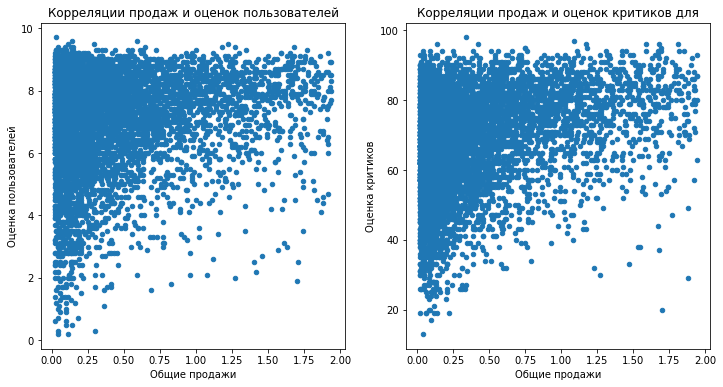

In [56]:
lower_bound = df['total_sales'].quantile(0.05)
upper_bound = df['total_sales'].quantile(0.95)
filtered_data = df[(df['total_sales'] >= lower_bound) & (df['total_sales'] <= upper_bound)]

# Создаем сетку подграфиков
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# График для user_score
filtered_data.plot(x='total_sales', y='user_score', kind='scatter', ax=axes[0])
axes[0].set_title(f'Корреляции продаж и оценок пользователей')
axes[0].set_ylabel('Оценка пользователей')
axes[0].set_xlabel(f'Общие продажи')

# График для critic_score
filtered_data.plot(x='total_sales', y='critic_score', kind='scatter', ax=axes[1])
axes[1].set_title(f'Корреляции продаж и оценок критиков для')
axes[1].set_ylabel('Оценка критиков')
axes[1].set_xlabel(f'Общие продажи')

plt.show()

<div class="alert alert-danger" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
✍ 
В задании нас просят: **Проанализируйте продажи игр на различных платформах.** Рекомендуется строить диаграммы рассеяния для нескольких платформ, а не просто опираться на расчет корреляции. Делая выводы на основе данных по пяти или более платформам, наш анализ будет более углубленным и убедительным. Для упрощения задачи, можно применить цикл.
</div>

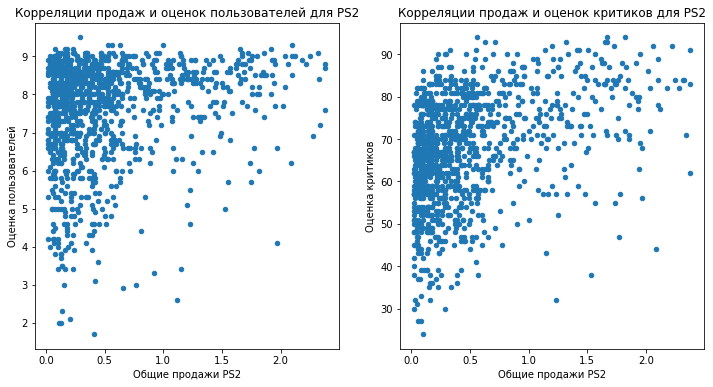

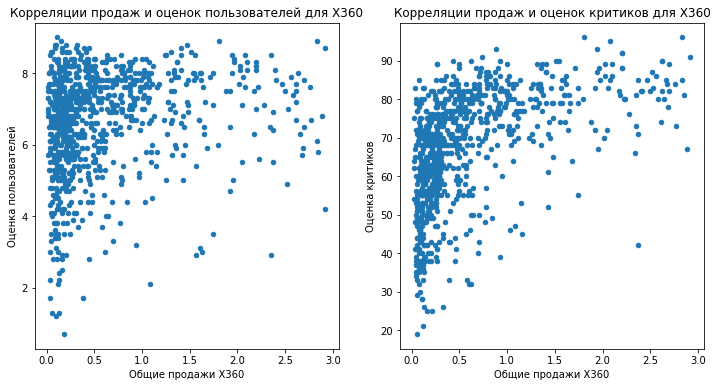

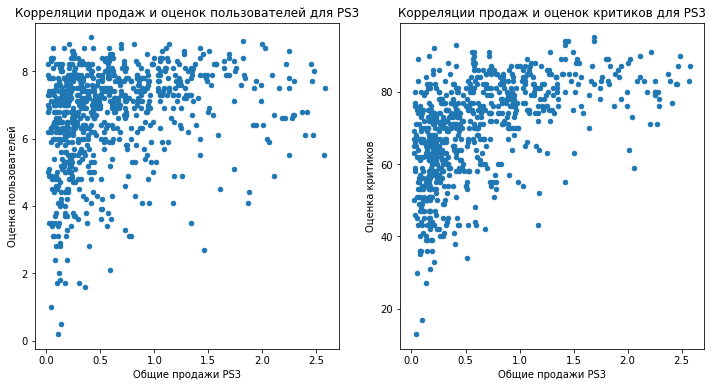

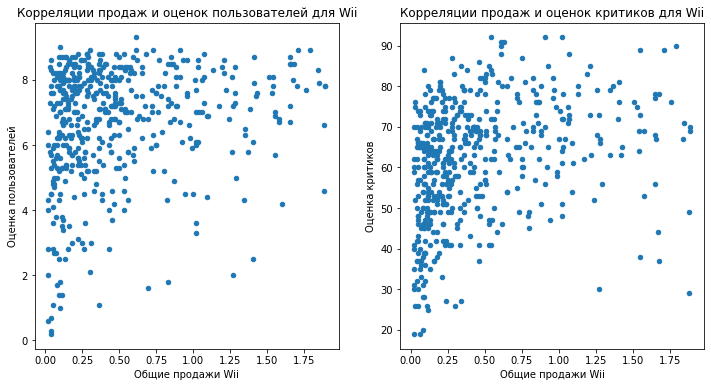

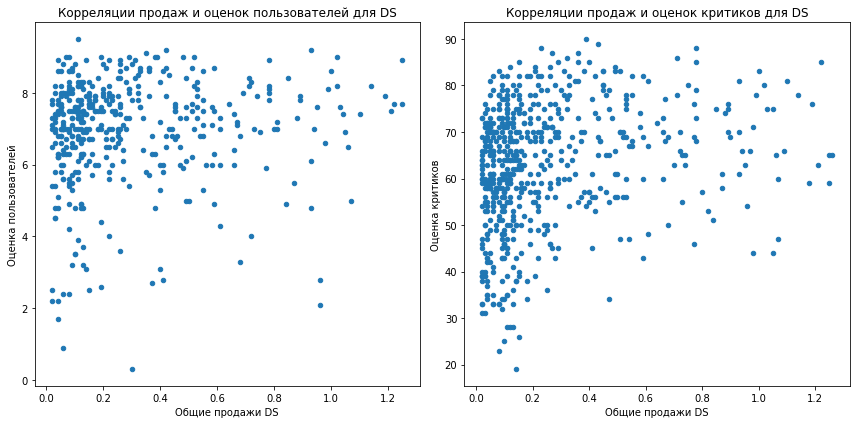

In [54]:
for platform in top_platforms:
    # Фильтруем данные для текущей платформы
    platform_data = df[df['platform'] == platform]
    lower_bound = platform_data['total_sales'].quantile(0.05)
    upper_bound = platform_data['total_sales'].quantile(0.95)
    platform_data = platform_data[(platform_data['total_sales'] >= lower_bound) & (platform_data['total_sales'] <= upper_bound)]

    # Создаем сетку подграфиков
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # График для user_score
    platform_data.plot(x='total_sales', y='user_score', kind='scatter', ax=axes[0])
    axes[0].set_title(f'Корреляции продаж и оценок пользователей для {platform}')
    axes[0].set_ylabel('Оценка пользователей')
    axes[0].set_xlabel(f'Общие продажи {platform}')

    # График для critic_score
    platform_data.plot(x='total_sales', y='critic_score', kind='scatter', ax=axes[1])
    axes[1].set_title(f'Корреляции продаж и оценок критиков для {platform}')
    axes[1].set_ylabel('Оценка критиков')
    axes[1].set_xlabel(f'Общие продажи {platform}')

# Отображение графиков
plt.tight_layout()
plt.show()

Исходя из значений корреляции Пирсона можно сделать выводы:
- Оценка критиков имеет слабую корреляцию с продажами.
- Оценка пользователей никак не влияет на продажи.

Диаграммы рассеяния для всех платформ вместе и для нескольких самых популярных платформ показывают, что хорошие отзывы не гарантируют хорошие продажи, но плохие отзывы гарантируют, что продажи будут низкими. Практически нет игр с плохими отзывами и хорошими продажами.

Для большей наглядности при построении графиком были исключены артефакты в виде 5% самых высоких и самых низких продаж, не отражающие типичную ситуацию.

## Жанры игр

In [43]:
# Количество выпущенных игр по жанрам
df3['genre'].value_counts()

Action          619
Role-Playing    221
Adventure       185
Sports          161
Shooter         128
Misc            113
Racing           69
Fighting         60
Simulation       44
Platform         38
Strategy         37
Puzzle           14
Name: genre, dtype: int64

In [44]:
df3.groupby('genre')['total_sales'].describe().sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Shooter,128.00,1.34,2.05,0.01,0.17,0.52,1.62,14.63
Sports,161.00,0.68,1.24,0.01,0.06,0.18,0.64,8.58
Platform,38.00,0.48,0.72,0.01,0.06,0.14,0.47,3.21
Fighting,60.00,0.47,1.19,0.01,0.06,0.12,0.32,7.55
Role-Playing,221.00,0.46,1.18,0.01,0.05,0.11,0.36,11.68
Racing,69.00,0.40,0.96,0.01,0.03,0.09,0.25,7.09
Misc,113.00,0.33,0.74,0.01,0.03,0.09,0.32,5.27
Action,619.00,0.32,0.80,0.01,0.03,0.09,0.28,12.62
Simulation,44.00,0.30,0.65,0.01,0.02,0.10,0.33,3.05


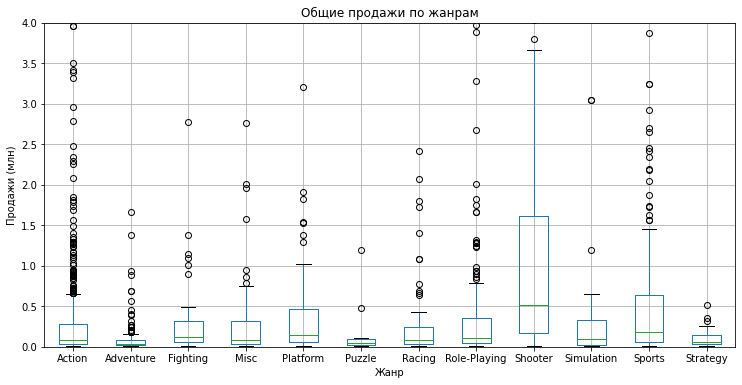

In [45]:
df3.boxplot('total_sales', by='genre',figsize=(12,6)).set_ylim([0, 4])
plt.title('Общие продажи по жанрам')
plt.suptitle('')
plt.xlabel('Жанр')
plt.ylabel('Продажи (млн)')
plt.show()

Наиболее часто встречаемый жанр - `Action`.
Больше всего продаж у игр жанра `Shooter`.

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Верно. Общие продажи - плохая метрика для поиска наиболее прибыльного жанра. За высокими показателями общих продаж может скрываться множество мелких игр с низкими продажами. Или 2-3 звезды и куча провалов. Лучше найти жанр, где игры стабильно приносят высокий доход - для этого стоит рассматривать средние или медианные продажи.
</div>

## Регионы

Определите для пользователя каждого региона (NA, EU, JP):

    Самые популярные платформы (топ-5). Опишите различия в долях продаж.
    Самые популярные жанры (топ-5). Поясните разницу.
    Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [61]:
top_platforms_region = set()
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    print(f"Топ-5 платформ для региона {region}:")
    platforms_region = df3.groupby('platform')[region].sum().sort_values(ascending=False).head(5)
    print(*platforms_region.index, sep=', ')
    print()
    # Список наиболее популярных платформ в разных регионах
    top_platforms_region.update(platforms_region.index)

Топ-5 платформ для региона na_sales:
PS4, XOne, X360, 3DS, PS3

Топ-5 платформ для региона eu_sales:
PS4, XOne, PS3, PC, 3DS

Топ-5 платформ для региона jp_sales:
3DS, PS4, PSV, PS3, WiiU



{'3DS', 'PC', 'PS3', 'PS4', 'PSV', 'WiiU', 'X360', 'XOne'}

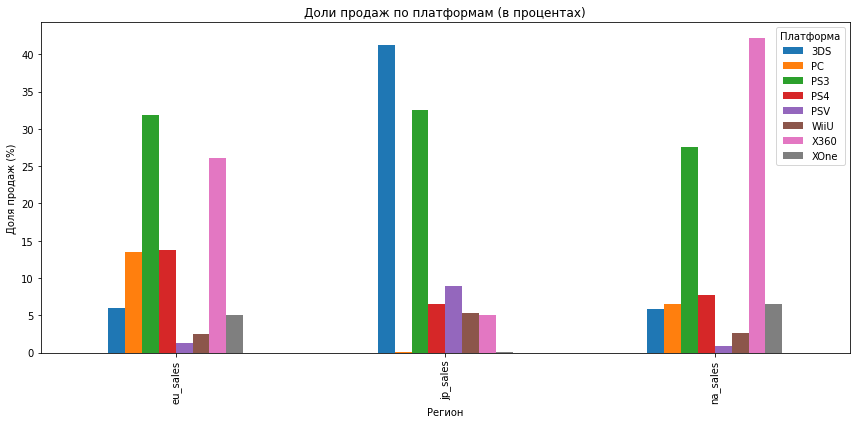

In [77]:
# Для ясности рассматриваем только самые популярные платформы
df_platforms = df[df['platform'].isin(top_platforms_region)]
sales_by_platform = df_platforms.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
total_sales = df_platforms[['na_sales', 'eu_sales', 'jp_sales']].sum()
sales_by_platform_share = sales_by_platform.div(total_sales) * 100

sales_by_platform_share.T.plot(kind='bar', figsize=(12, 6))
plt.title('Доли продаж по платформам (в процентах)')
plt.xlabel('Регион')
plt.ylabel('Доля продаж (%)')
plt.legend(title='Платформа')
plt.tight_layout()
plt.show()

Рынки Северной Америки и Европы похожи. В Японии популярны другие платформы.

Разница в популярности платформ может объясняться несколькими факторами:

Культурные особенности: В Японии традиционно сильна портативная игровая культура, что объясняет высокую популярность 3DS и PSV.
Маркетинговые стратегии: Компании могут делать акцент на продвижение определенных платформ в разных регионах.
Эксклюзивные игры: Наличие эксклюзивных игр на платформе может существенно влиять на ее продажи в конкретном регионе.

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Верная интерпретация полученных данных.
</div>

In [86]:
top_genres_region = set()
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    print(f"Топ-5 жанров для региона {region}:")
    genres_region = df3.groupby('genre')[region].sum().sort_values(ascending=False).head(5)
    print(*genres_region.index, sep=', ')
    print()
    # Список наиболее популярных жанров в разных регионах
    top_genres_region.update(genres_region.index)

Топ-5 жанров для региона na_sales:
Shooter, Action, Sports, Role-Playing, Misc

Топ-5 жанров для региона eu_sales:
Action, Shooter, Sports, Role-Playing, Racing

Топ-5 жанров для региона jp_sales:
Role-Playing, Action, Fighting, Misc, Shooter



<div class="alert alert-warning" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
📝 
Но, хорошо бы визуализировать полученную информацию.
</div>

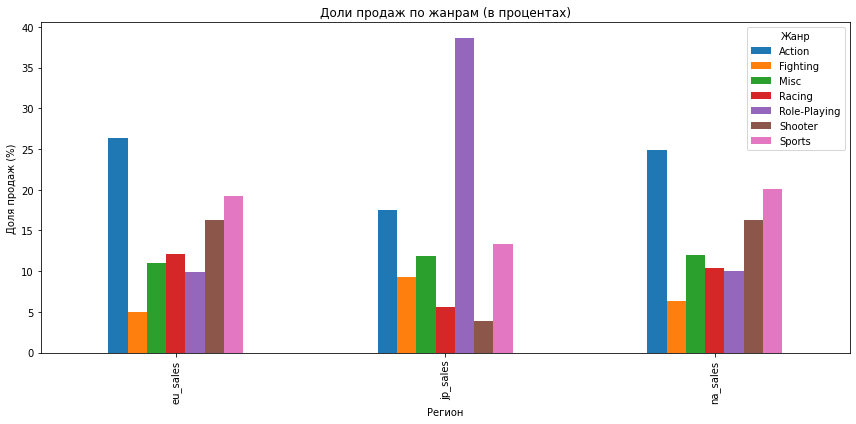

In [89]:
# Для ясности рассматриваем только самые популярные жанры
df_genres = df[df['genre'].isin(top_genres_region)]
sales_by_genre = df_genres.pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
total_sales = df_genres[['na_sales', 'eu_sales', 'jp_sales']].sum()
sales_by_genre_share = sales_by_genre.div(total_sales) * 100

sales_by_genre_share.T.plot(kind='bar', figsize=(12, 6))
plt.title('Доли продаж по жанрам (в процентах)')
plt.xlabel('Регион')
plt.ylabel('Доля продаж (%)')
plt.legend(title='Жанр')
plt.tight_layout()
plt.show()

В Северной Америке и Европе лидируют Action, Shooter и Sports. В Японии Role-Playing занимает первое место, а Action только четвертое.

Это может быть связано с культурными особенностями и предпочтениями игроков в разных регионах. Возможно, в Японии большую роль играет сюжет и глубина игрового мира, которые характерны для жанра Role-Playing. В Северной Америке и Европе, скорее всего, ценятся динамика и экшен, что отражается в популярности Action и Shooter.

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Согласен, NA и EU во многом схожи, в то время, как Япония более самобытна.
</div>

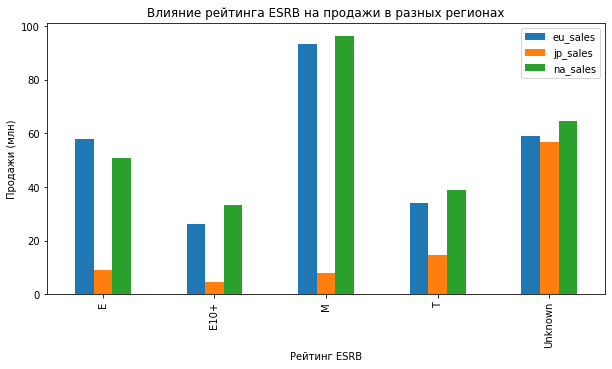

In [63]:
# Создаем сводную таблицу
sales_by_rating = df3.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')

# Строим график
sales_by_rating.plot(kind='bar', figsize=(10, 5))
plt.title('Влияние рейтинга ESRB на продажи в разных регионах')
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Продажи (млн)')
plt.show()

<div class="alert alert-danger" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
✍ 
А что мы можем сказать по играм без рейтинга?
</div>

Влияние рейтинга ESRB на продажи различается в зависимости от региона.

В Северной Америке и Европе игры с рейтингом "M" (Mature) имеют наибольшие продажи.
В Японии игры с рейтингом "T" (Teen) продаются лучше всего.

Продажи игр без рейтинга примерно одинаковы во всех регионах. Возможно, в исходных данных рейтинг пропущен полностью случайно, поэтому в него равномерно попадают игры всех рейтингов.

# Общий вывод

В ходе работы были проанализированы данные о продаже компьютерных игр по всему миру до 2016 года.

Исходный массив данных содержит 16715 записей об играх с различными характеристиками, такими как название, платформа, год выпуска, жанр, продажи в разных регионах, оценки критиков и пользователей.


В результате предобработки данных:
- Были скорректированы названия и типы данных в столбцах.
- Удалены дубликаты и пропуски в данных.
- Добавлены новые столбцы для удобства анализа (суммарные продажи).

Основные выводы по итогам анализа:
- Наибольшее количество игр выпускалось в 2008 и 2009 годах.
- Самые популярные платформы - PS2, X360, PS3, Wii, DS.
- Средний срок жизни платформы 6 лет.
- Cредний срок жизни популярных платформ 10 лет.
- Потенциально прибыльными платформами можно считать PS4 и XOne.
- Оценка критиков имеет слабую корреляцию с продажами.
- Оценка пользователей никак не влияет на продажи.
- Наиболее часто встречаемый жанр - Action.
- Больше всего продаж у игр жанра Shooter.
- Рынки Северной Америки и Европы похожи. В Японии популярны другие платформы (3DS и PSV).
- В Северной Америке и Европе лидируют Action, Shooter и Sports. В Японии Role-Playing занимает первое место.
- Влияние рейтинга ESRB на продажи различается в зависимости от региона. В Северной Америке и Европе игры с рейтингом "M" (Mature) имеют наибольшие продажи. В Японии игры с рейтингом "T" (Teen) продаются лучше всего.

<div class="alert alert-danger" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
✍ 
В общем и целом вывод верный. Однако для большей наглядности для заказчика предлагаю структурировать итоговые выводы, выделяя ключевые аспекты работы. В финальном разделе стоит максимально детализировать и обогатить информацией с конкретными цифрами все найденные закономерности и особенности в данных в ходе исследования.

Давай сделаем обзорную часть более развернутой, чтобы подчеркнуть качество проведенной работы и предоставить заказчику полное понимание проведенного анализа.
</div>

<div style="border:solid indigo 3px; padding: 20px">
<div class="alert alert-success">
<b>Обратная связь v.1</b> 
    
👋  
Артем, хорошая работа, ты мыслишь нестандартно, это отличный навык, который у тебя уже есть, ты последователен и вдумчив. Твою работу очень интересно читать и проверять.  Я оставил несколько обязательных поправок для тебя и после этого буду готов сразу принять проект. 

Удачи в доработках, жду!  